NEURAL NETWORKS FOR CFD - PROJECT WORK

In [ ]:
pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.3/192.3 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 6.0 MB/s eta 0:00:00


Burger's Equation

Compiling model...
Building feed-forward neural network...
'build' took 0.110568 s

'compile' took 2.111276 s

Training model...

0         [7.84e-02, 0.00e+00, 1.06e+01]    [7.84e-02, 0.00e+00, 1.06e+01]    []  
1000      [9.11e-02, 0.00e+00, 8.25e-03]    [9.11e-02, 0.00e+00, 8.25e-03]    []  
2000      [7.74e-02, 0.00e+00, 5.28e-03]    [7.74e-02, 0.00e+00, 5.28e-03]    []  
3000      [6.94e-02, 0.00e+00, 4.56e-03]    [6.94e-02, 0.00e+00, 4.56e-03]    []  
4000      [5.88e-02, 0.00e+00, 3.66e-03]    [5.88e-02, 0.00e+00, 3.66e-03]    []  
5000      [2.03e-02, 0.00e+00, 1.68e-03]    [2.03e-02, 0.00e+00, 1.68e-03]    []  

Best model at step 5000:
  train loss: 2.20e-02
  test loss: 2.20e-02
  test metric: []

'train' took 416.411102 s

Compiling model...
'compile' took 1.473192 s

Training model...

Step      Train loss                        Test loss                         Test metric
5000      [2.03e-02, 0.00e+00, 1.68e-04]    [2.03e-02, 0.00e+00, 1.68e-04]    []  
5017      [2.03e-

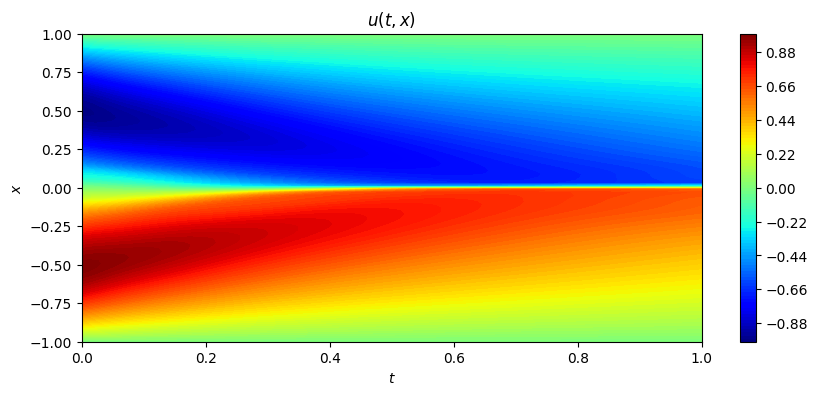

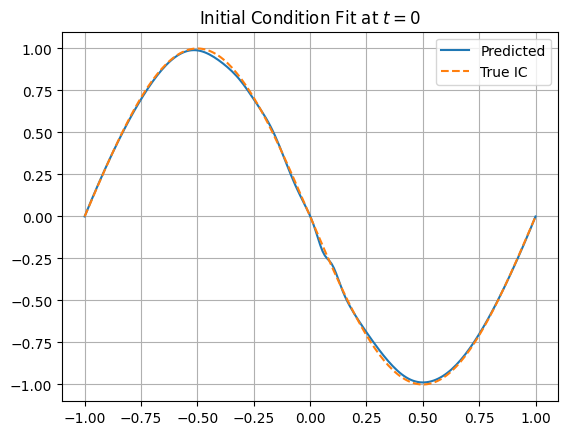

In [ ]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
dde.config.set_random_seed(42)

# Define the PDE: Burgers' Equation
def pde(x, u):
    du_x = dde.grad.jacobian(u, x, i=0, j=0)
    du_t = dde.grad.jacobian(u, x, i=0, j=1)
    du_xx = dde.grad.hessian(u, x, i=0, j=0)
    nu = 0.01 / np.pi
    return du_t + u * du_x - nu * du_xx

# Geometry and time domain
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Initial condition: u(x, 0) = -sin(pi * x)
def initial_condition(x):
    return -np.sin(np.pi * x[:, 0:1])

ic = dde.icbc.IC(geomtime, initial_condition, lambda x, on_initial: on_initial)

# Boundary condition: u(-1, t) = u(1, t) = 0
bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda x, on_boundary: on_boundary)

# Define the neural network
net = dde.nn.FNN([2] + [50] * 3 + [1], "tanh", "Glorot normal")

# Output transform to enforce u(-1) = u(1) = 0
def output_transform(x, y):
    return (1 - x[:, 0:1]**2) * y  # zero at x = -1, 1

net.apply_output_transform(output_transform)

# Define model
data = dde.data.TimePDE(
    geomtime, pde, [bc, ic], num_domain=2000, num_boundary=2000, num_initial=2000
)

model = dde.Model(data, net)

# Compile and train
model.compile("adam", lr=1e-3, loss_weights=[1, 1, 10])
losshistory, train_state = model.train(epochs=5000)

# Optionally fine-tune with L-BFGS-B optimizer
model.compile("L-BFGS-B")
model.train()

# Predict and plot solution
x = np.linspace(-1, 1, 100)
t = np.linspace(0, 1, 100)
X, T = np.meshgrid(x, t)
XT = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

u_pred = model.predict(XT)
U_pred = u_pred.reshape(100, 100)

# Contour plot
plt.figure(figsize=(10, 4))
cp = plt.contourf(T, X, U_pred, 100, cmap="jet")
plt.colorbar(cp)
plt.xlabel("$t$")
plt.ylabel("$x$")
plt.title("$u(t,x)$")
plt.show()

# Check IC fit
x_ic = np.linspace(-1, 1, 200)[:, None]
t0 = np.zeros_like(x_ic)
xt0 = np.hstack((x_ic, t0))
u0_pred = model.predict(xt0)

plt.plot(x_ic, u0_pred, label="Predicted")
plt.plot(x_ic, -np.sin(np.pi * x_ic), "--", label="True IC")
plt.title("Initial Condition Fit at $t=0$")
plt.legend()
plt.grid(True)
plt.show()


Navier Stokes Equation

In [ ]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import scipy.io

# Load data
data = scipy.io.loadmat("cylinder_nektar_wake.mat")
X_star = data["X_star"]        # (N, 2)
U_star = data["U_star"]        # (N, 200, 2)
P_star = data["p_star"]        # (N, 200)
t_star = data["t"].flatten()   # (200,)

print(f"Available time steps: {len(t_star)}")
target_time = 0.0
time_index = np.argmin(np.abs(t_star - target_time))
print(f"Chosen time: {t_star[time_index]:.2f} (index {time_index})")

# Extract data at chosen time
x_data = X_star[:, 0:1]
y_data = X_star[:, 1:2]
u_data = U_star[:, time_index, 0:1]
v_data = U_star[:, time_index, 1:2]
p_data = P_star[:, time_index:time_index+1]

X_input = np.hstack((x_data, y_data))

# Domain
xmin = X_input.min(axis=0)
xmax = X_input.max(axis=0)
geom = dde.geometry.Rectangle(xmin, xmax)

# Define trainable parameters
lambda1 = dde.Variable(0.01)
lambda2 = dde.Variable(1.0)

# PDE definition
def navier_stokes(x, y):
    u, v, p = y[:, 0:1], y[:, 1:2], y[:, 2:3]
    du_x = dde.grad.jacobian(y, x, i=0, j=0)
    du_y = dde.grad.jacobian(y, x, i=0, j=1)
    dv_x = dde.grad.jacobian(y, x, i=1, j=0)
    dv_y = dde.grad.jacobian(y, x, i=1, j=1)
    dp_x = dde.grad.jacobian(y, x, i=2, j=0)
    dp_y = dde.grad.jacobian(y, x, i=2, j=1)

    d2u_xx = dde.grad.hessian(y, x, i=0, j=0)
    d2u_yy = dde.grad.hessian(y, x, i=0, j=1)
    d2v_xx = dde.grad.hessian(y, x, i=1, j=0)
    d2v_yy = dde.grad.hessian(y, x, i=1, j=1)

    eq1 = u * du_x + v * du_y + lambda2 * dp_x - lambda1 * (d2u_xx + d2u_yy)
    eq2 = u * dv_x + v * dv_y + lambda2 * dp_y - lambda1 * (d2v_xx + d2v_yy)
    eq3 = du_x + dv_y
    return [eq1, eq2, eq3]

# Observations from dataset
observe_u = dde.PointSetBC(X_input, u_data, component=0)
observe_v = dde.PointSetBC(X_input, v_data, component=1)
observe_p = dde.PointSetBC(X_input, p_data, component=2)

# Data
data = dde.data.PDE(
    geom,
    navier_stokes,
    [observe_u, observe_v, observe_p],
    num_domain=10000,  # Sample size from the interior domain
)



# Model
net = dde.maps.FNN([2] + [100] * 6 + [3], "tanh", "Glorot normal")
model = dde.Model(data, net)

# Compile and train
model.compile("adam", lr=1e-3, external_trainable_variables=[lambda1, lambda2])
losshistory, train_state = model.train(epochs=10000)




Available time steps: 200
Chosen time: 0.00 (index 0)
Compiling model...
Building feed-forward neural network...
'build' took 0.101530 s

'compile' took 1.372741 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [3.04e-03, 5.44e-03, 4.05e-03, 3.12e-01, 3.86e-01, 9.08e-02]    [3.04e-03, 5.44e-03, 4.05e-03, 3.12e-01, 3.86e-01, 9.08e-02]    []  
1000      [5.53e-03, 2.41e-03, 6.98e-03, 3.30e-02, 3.70e-02, 6.80e-03]    [5.53e-03, 2.41e-03, 6.98e-03, 3.30e-02, 3.70e-02, 6.80e-03]    []  
2000      [5.35e-03, 1.70e-03, 8.27e-03, 2.75e-02, 3.08e-02, 6.31e-03]    [5.35e-03, 1.70e-03, 8.27e-03, 2.75e-02, 3.08e-02, 6.31e-03]    []  
3000      [5.10e-03, 1.20e-03, 8.62e-03, 2.64e-02, 3.09e-02, 6.31e-03]    [5.10e-03, 1.20e-03, 8.62e-03, 2.64e-02, 3.09e-02, 6.31e-03]    []  
4000      [4.33e-03, 2.87e-03, 9.07e-03, 2.66e-02, 3.13e-02, 6.24e-03]    [4.33e-03, 2.87e-03,

Learned Parameters:
lambda1 (viscosity): 0.01
lambda2 (pressure scaling): 1.0


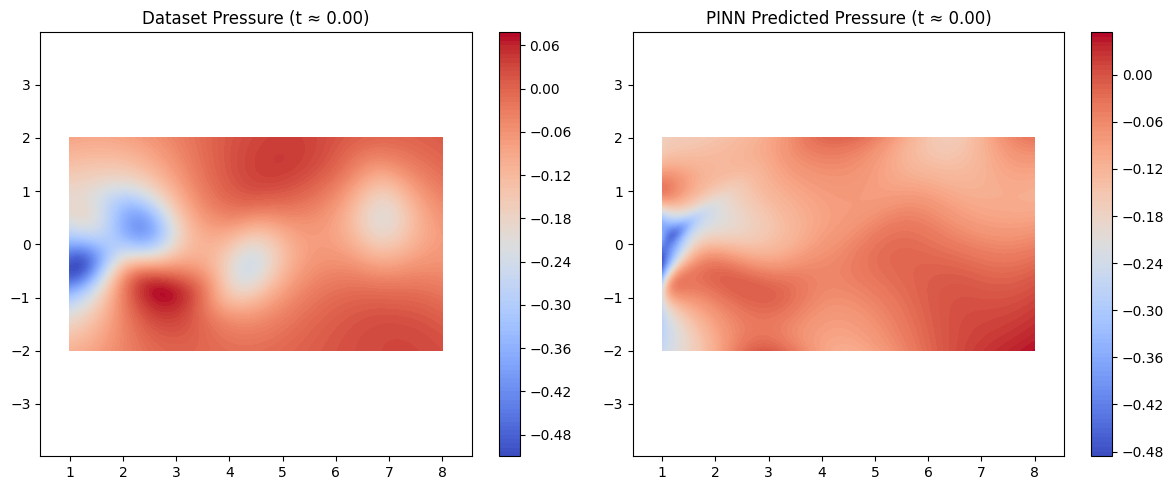

In [ ]:
import tensorflow as tf
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import scipy.io

from deepxde.backend import tf

import tensorflow as tf

# Evaluate using a session (this works even with RefVariables)
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())  # If not already initialized
    lambda1_val, lambda2_val = sess.run([lambda1, lambda2])
    print("Learned Parameters:")
    print("lambda1 (viscosity):", lambda1_val)
    print("lambda2 (pressure scaling):", lambda2_val)


# Prediction
pred = model.predict(X_input)
p_pred = pred[:, 2:3]

# Interpolation
xi = np.linspace(x_data.min(), x_data.max(), 300)
yi = np.linspace(y_data.min(), y_data.max(), 300)
X_grid, Y_grid = np.meshgrid(xi, yi)

P_grid_dataset = griddata((x_data.flatten(), y_data.flatten()), p_data.flatten(), (X_grid, Y_grid), method="cubic")
P_grid_pred = griddata((x_data.flatten(), y_data.flatten()), p_pred.flatten(), (X_grid, Y_grid), method="cubic")

# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.contourf(X_grid, Y_grid, P_grid_dataset, levels=100, cmap="coolwarm")
plt.colorbar()
plt.title(f"Dataset Pressure (t ≈ {t_star[time_index]:.2f})")
plt.axis("equal")

plt.subplot(1, 2, 2)
plt.contourf(X_grid, Y_grid, P_grid_pred, levels=100, cmap="coolwarm")
plt.colorbar()
plt.title(f"PINN Predicted Pressure (t ≈ {t_star[time_index]:.2f})")
plt.axis("equal")

plt.tight_layout()
plt.show()


In [ ]:
from google.colab import files  # Only for Colab
uploaded = files.upload()       # This will prompt you to upload the file


Saving cylinder_nektar_wake.mat to cylinder_nektar_wake.mat


Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)
Compiling model...
Building feed-forward neural network...
'build' took 0.094636 s

'compile' took 3.465892 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.73e-02, 4.81e-03, 3.66e-02, 8.23e-01, 8.58e-01, 2.72e-02]    [1.73e-02, 4.81e-03, 3.66e-02, 8.23e-01, 8.58e-01, 2.72e-02]    []  
100       [1.41e-03, 6.07e-04, 1.81e-03, 7.36e-02, 7.30e-02, 8.70e-03]    [1.41e-03, 6.07e-04, 1.81e-03, 7.36e-02, 7.30e-02, 8.70e-03]    []  
200       [1.82e-03, 1.07e-03, 1.93e-03, 6.23e-02, 6.19e-02, 8.57e-03]    [1.82e-03, 1.07e-03, 1.93e-03, 6.23e-02, 6.19e-02, 8.57e-03]    []  
300       [6.02e-03, 2.31e-03, 1.96e-03, 5.02

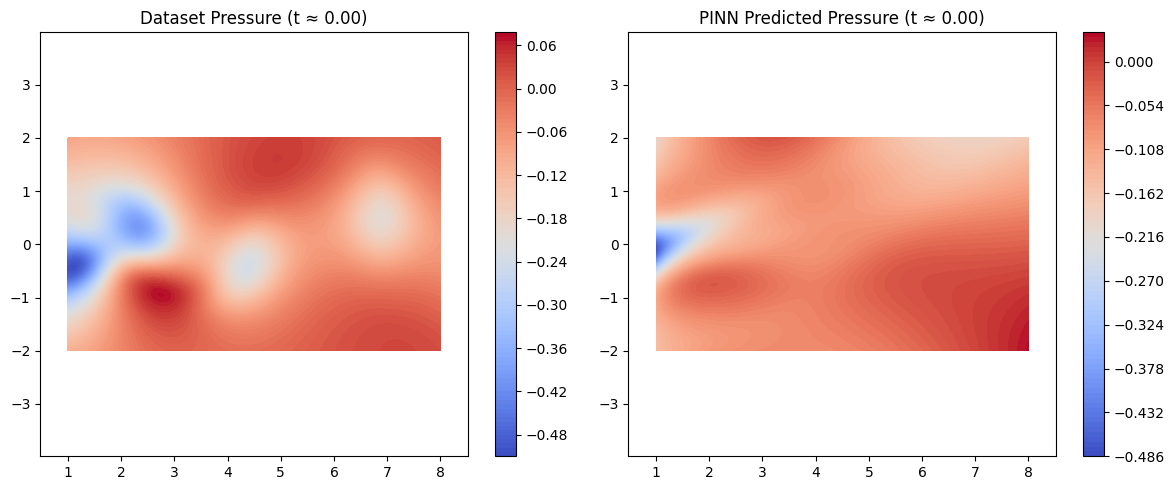

Learned lambda1 (viscosity): -0.5152615
Learned lambda2 (pressure scaling): 2.991764


In [ ]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import scipy.io
import tensorflow as tf
import random

dde.backend.set_default_backend("tensorflow.compat.v1")

# ---------------- Load Data ----------------
data = scipy.io.loadmat("cylinder_nektar_wake.mat")



X_star = data["X_star"]        # (N, 2)
U_star = data["U_star"]        # (N, 200, 2)
P_star = data["p_star"]        # (N, 200)
t_star = data["t"].flatten()   # (200,)

target_time = 0.0
time_index = np.argmin(np.abs(t_star - target_time))

x_data = X_star[:, 0:1]
y_data = X_star[:, 1:2]
u_data = U_star[:, time_index, 0:1]
v_data = U_star[:, time_index, 1:2]
p_data = P_star[:, time_index:time_index+1]

X_input = np.hstack((x_data, y_data))

# Normalize input
x_mean, x_std = X_input.mean(0), X_input.std(0)
X_input_norm = (X_input - x_mean) / x_std

# ---------------- Domain ----------------
xmin = X_input_norm.min(0)
xmax = X_input_norm.max(0)
geom = dde.geometry.Rectangle(xmin, xmax)

# ---------------- Trainable Parameters ----------------
lambda1 = tf.Variable(0.01, trainable=True, dtype=tf.float32)
lambda2 = tf.Variable(1.0, trainable=True, dtype=tf.float32)

# ---------------- PDE ----------------
def navier_stokes(x, y):
    u, v, p = y[:, 0:1], y[:, 1:2], y[:, 2:3]
    du_x = dde.grad.jacobian(y, x, i=0, j=0)
    du_y = dde.grad.jacobian(y, x, i=0, j=1)
    dv_x = dde.grad.jacobian(y, x, i=1, j=0)
    dv_y = dde.grad.jacobian(y, x, i=1, j=1)
    dp_x = dde.grad.jacobian(y, x, i=2, j=0)
    dp_y = dde.grad.jacobian(y, x, i=2, j=1)

    d2u_xx = dde.grad.hessian(y, x, i=0, j=0)
    d2u_yy = dde.grad.hessian(y, x, i=0, j=1)
    d2v_xx = dde.grad.hessian(y, x, i=1, j=0)
    d2v_yy = dde.grad.hessian(y, x, i=1, j=1)

    eq1 = u * du_x + v * du_y + lambda2 * dp_x - lambda1 * (d2u_xx + d2u_yy)
    eq2 = u * dv_x + v * dv_y + lambda2 * dp_y - lambda1 * (d2v_xx + d2v_yy)
    eq3 = du_x + dv_y
    return [eq1, eq2, eq3]

# ---------------- Boundary Conditions ----------------
observe_u = dde.PointSetBC(X_input_norm, u_data, component=0)
observe_v = dde.PointSetBC(X_input_norm, v_data, component=1)
observe_p = dde.PointSetBC(X_input_norm, p_data, component=2)

# ---------------- Dataset ----------------
data = dde.data.PDE(
    geom,
    navier_stokes,
    [observe_u, observe_v, observe_p],
    num_domain=5000,
    anchors=X_input_norm,
)

# ---------------- Network ----------------
net = dde.maps.FNN([2] + [50]*5 + [3], "tanh", "Glorot normal")

# ---------------- Model ----------------
model = dde.Model(data, net)

# Set random seeds
random.seed(42)
np.random.seed(42)
tf.compat.v1.set_random_seed(42)

# Compile and train with Adam
model.compile("adam", lr=1e-3, external_trainable_variables=[lambda1, lambda2])
model.train(iterations=5000, display_every=100)

# Fine-tune with L-BFGS
model.compile("L-BFGS", external_trainable_variables=[lambda1, lambda2])
model.train()

# ---------------- Predict ----------------
X_input_norm_test = (X_input - x_mean) / x_std
pred = model.predict(X_input_norm_test)
p_pred = pred[:, 2:3]

# ---------------- Plot ----------------
xi = np.linspace(x_data.min(), x_data.max(), 300)
yi = np.linspace(y_data.min(), y_data.max(), 300)
X_grid, Y_grid = np.meshgrid(xi, yi)

P_grid_dataset = griddata((x_data.flatten(), y_data.flatten()), p_data.flatten(), (X_grid, Y_grid), method="cubic")
P_grid_pred = griddata((x_data.flatten(), y_data.flatten()), p_pred.flatten(), (X_grid, Y_grid), method="cubic")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.contourf(X_grid, Y_grid, P_grid_dataset, levels=100, cmap="coolwarm")
plt.colorbar()
plt.title(f"Dataset Pressure (t ≈ {t_star[time_index]:.2f})")
plt.axis("equal")

plt.subplot(1, 2, 2)
plt.contourf(X_grid, Y_grid, P_grid_pred, levels=100, cmap="coolwarm")
plt.colorbar()
plt.title(f"PINN Predicted Pressure (t ≈ {t_star[time_index]:.2f})")
plt.axis("equal")

plt.tight_layout()
plt.show()

# Print learned parameters
print("Learned lambda1 (viscosity):", model.sess.run(lambda1))
print("Learned lambda2 (pressure scaling):", model.sess.run(lambda2))


Korteweg-de Vries Equation

In [ ]:
import deepxde as dde
import numpy as np
import tensorflow as tf

# Define geometry and time
geom = dde.geometry.Interval(-5, 5)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Define trainable parameters
lambda1 = tf.Variable(1.0)
lambda2 = tf.Variable(1.0)

# KdV equation: u_t + λ1 * u * u_x + λ2 * u_xxx = 0
def pde(x, u):
    du_t = dde.grad.jacobian(u, x, j=1)
    du_x = dde.grad.jacobian(u, x, j=0)
    du_xxx = dde.grad.hessian(u, x, i=0, j=0, component=0)
    du_xxx = dde.grad.jacobian(du_xx := dde.grad.hessian(u, x, 0, 0), x, 0)

    return du_t + lambda1 * u * du_x + lambda2 * du_xxx

# Initial condition (same as the paper)
def initial_condition(x):
    return 0.5 * np.cosh(0.5 * x[:, 0]) ** (-2)

# Boundary condition: periodic
def boundary(x, on_boundary):
    return on_boundary

bc = dde.PeriodicBC(geomtime, lambda x: 0, boundary)
ic = dde.IC(geomtime, initial_condition, lambda _, on_initial: on_initial)

# Define data
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain=256,
    num_boundary=80,
    num_initial=160,
    solution=None,
    num_test=1000,
)

# Define neural network
net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot normal")

# Model
model = dde.Model(data, net)

# Compile & train
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=10000)




Compiling model...
Building feed-forward neural network...
'build' took 0.202277 s

'compile' took 2.726609 s

Training model...

0         [3.06e-01, 1.59e+01, 2.70e+00]    [3.61e-01, 1.59e+01, 2.70e+00]    []  
1000      [2.97e-05, 1.55e-06, 2.77e-02]    [5.53e-05, 1.55e-06, 2.77e-02]    []  
2000      [5.69e-06, 5.18e-08, 2.77e-02]    [9.80e-06, 5.18e-08, 2.77e-02]    []  
3000      [3.68e-06, 2.92e-08, 2.77e-02]    [5.77e-06, 2.92e-08, 2.77e-02]    []  
4000      [2.43e-06, 1.21e-08, 2.77e-02]    [3.93e-06, 1.21e-08, 2.77e-02]    []  
5000      [1.65e-06, 9.93e-09, 2.77e-02]    [2.68e-06, 9.93e-09, 2.77e-02]    []  
6000      [1.31e-06, 9.65e-09, 2.77e-02]    [2.12e-06, 9.65e-09, 2.77e-02]    []  
7000      [1.22e-06, 1.07e-08, 2.77e-02]    [2.00e-06, 1.07e-08, 2.77e-02]    []  
8000      [8.95e-07, 6.91e-09, 2.77e-02]    [1.45e-06, 6.91e-09, 2.77e-02]    []  
9000      [6.43e-07, 3.98e-09, 2.77e-02]    [1.01e-06, 3.98e-09, 2.77e-02]    []  
10000     [6.77e-07, 4.46e-05, 2.77e-02]

In [ ]:
import tensorflow.compat.v1 as tf1
tf1.disable_eager_execution()

with tf1.Session() as sess:
    sess.run(tf1.global_variables_initializer())  # Only if not already initialized
    lambda1_val = sess.run(lambda1)
    lambda2_val = sess.run(lambda2)

print("Learned lambda1 (nonlinearity):", lambda1_val)
print("Learned lambda2 (dispersion):", lambda2_val)



Learned lambda1 (nonlinearity): 1.0
Learned lambda2 (dispersion): 1.0


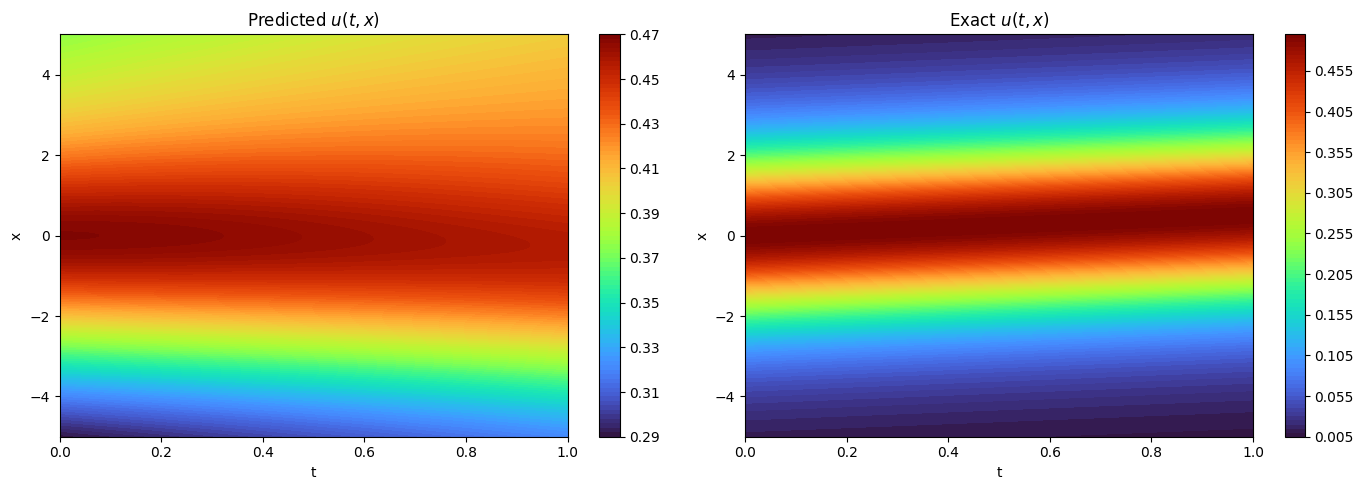

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Predicted
cp = axs[0].contourf(t, x, u_pred.T, 100, cmap="turbo")
fig.colorbar(cp, ax=axs[0])
axs[0].set_title("Predicted $u(t,x)$")
axs[0].set_xlabel("t")
axs[0].set_ylabel("x")

# Exact
cp = axs[1].contourf(t, x, u_exact.T, 100, cmap="turbo")
fig.colorbar(cp, ax=axs[1])
axs[1].set_title("Exact $u(t,x)$")
axs[1].set_xlabel("t")
axs[1].set_ylabel("x")

plt.tight_layout()
plt.show()
